# Fast transforms
## Last time

* Careers in/around numerical computing
* The autonomy-security spectrum

## Today

* Presentation guidelines, portfolio meetings
* Fast Fourier Transform

In [1]:
using LinearAlgebra
using Plots
default(linewidth=3, legendfontsize=12, xtickfontsize=12, ytickfontsize=12)

# Project presentations

* Remember to sign up (link is on Zulip)!
* We'll have about 8 presentations/day, so plan on 5 minutes plus questions/transition
* Let me know if you'll be producing a video for me to play instead of presenting live
* Link your repository and presentation in the sign-up sheet at least an hour before class

## Suggested Structure
* Motivation (why did you create what you did?)
* What and How (what did you create and how did you coordinate as a team)
* Metrics/Quality (how do you assess that what you did is correct, and how do you compare with related work)?
  * Concepts from class are likely to appear here (conditioning, stability, accuracy-vs-cost diagrams)
* Impacts
  * Who does what you created (or the software you evaluated) benefit and how?
  * What negative impacts can you envision and who might be impacted?

# Portfolio meetings

* Please choose a slot on Canvas, any time *after* your group presents.
* May be in-person or on Zoom

## Structure
* What goals did you set for yourself and how did they evolve?
  * You may point to examples/explanations in your journal.
* What are you most proud of this semester?
  * Please share examples from your portfolio or other work you did for the class.
* What are your career goals and how do you see numerical computation fitting in?
* If you could go back to January, what advice would you give your former self?
* What advice would you give me to make the class better meet your needs?
* What letter grade would you say accurately reflects your growth and quality of work this semester?

# Discrete signals

Consider a function $f(x)$ defined on an integer grid $x \in \mathbb Z$.

We also consider the Fourier modes
$$ \phi(x, \theta) = e^{i\theta x} $$
for continuous $\theta$.
Is it possible to distinguish $e^{i\theta x}$ from $e^{i(\theta+2\pi)x}$?

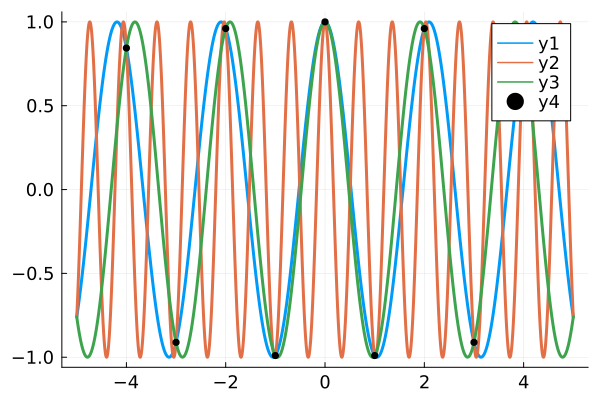

In [2]:
phi(x, theta) = exp(1im * theta * x)
rphi(x, theta) = real(phi(x, theta)) # real part
x = -4:4
theta = 3
plot([x -> rphi(x, theta), x -> rphi(x, theta+2π), x -> rphi(x, theta-2π)])
scatter!(x, rphi.(x, theta), color=:black)

We say $\theta = \pm \pi$ is the [Nyquist Frequency](https://en.wikipedia.org/wiki/Nyquist_frequency) for the integer grid.
* It corresponds to "two points per wavelength"

# Approximation by Fourier basis

Just like we can approximate functions using linear combinations of polynomials, we can approximate *periodic* functions using a linear combination of Fourier modes.

$$ f(x) \approx \sum_{k=1}^n \underbrace{\hat f(\theta_k)}_{\hat f_k} e^{i\theta_k x} . $$

This is reminiscent of linear algebra

\begin{align} \Bigg[ f(x) \Bigg] &= \Bigg[ e^{i\theta_1 x} \Bigg| e^{i\theta_2 x} \Bigg| \dotsm \Bigg] \begin{bmatrix} \hat f_1 \\ \hat f_2 \\ \vdots \end{bmatrix} \\
&= \Bigg[ e^{i\theta_1 x} \Bigg] \hat f_1 + \Bigg[ e^{i\theta_2 x} \Bigg] \hat f_2 + \dotsb .
\end{align}


## Continuous  $\theta$: infinite domain

If we take $\theta \in (-\pi, \pi]$ as a continuous quantity (instead of a discrete set of modes), the sum becomes and integral and we get equality (for "nice enough" $f(x)$),

$$ f(x) = \int_{-\pi}^\pi \hat f(\theta) e^{i\theta x} d\theta, $$

in which $\hat f(\theta)$ is the Fourier transform (specifically, the [discrete time transform](https://en.wikipedia.org/wiki/Discrete-time_Fourier_transform)) of $f(x)$.  This representation is valuable for analyzing convergence of multigrid methods, among other applications.


# Computing $\hat f(\theta)$

If we select a finite number of points $x$ and compute the square Vandermonde matrix

$$ \mathcal F = \Bigg[ e^{i\theta_1 x} \Bigg| e^{i\theta_2 x} \Bigg| \dotsm \Bigg] $$

then, knowing the vector $f$, we could solve

$$ \mathcal F \hat f = f $$

for $\hat f$.  This would require $O(n^3)$ where $n$ is the number of points.

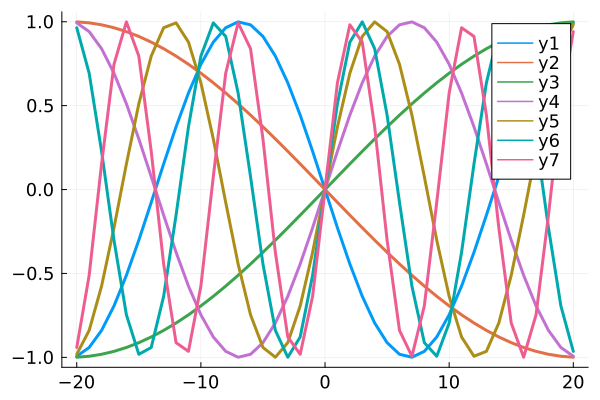

In [3]:
function vander_fourier(x, n=nothing)
    if isnothing(n)
        n = length(x)
    end
    theta = LinRange(-pi + 2pi/n, pi, n)
    F = exp.(1im * x * theta')
end

x = LinRange(-20, 20, 41)
F = vander_fourier(x)
plot(x, imag.(F[:, 19:25]))

# $\mathcal F$ as a matrix

In [4]:
x = LinRange(-2, 2, 5)
F = vander_fourier(x) / sqrt(5)
@show norm(F' * F - I)
@show norm(F * F' - I);

norm(F' * F - I) = 4.0067422874877247e-16
norm(F * F' - I) = 4.594822717058422e-16


* Every $\mathcal F$ (suitably normalized) is a unitary matrix
  * a unitary matrix is the complex-valued generalization of "orthogonal matrix"
  * $\mathcal F^H \mathcal F = \mathcal F \mathcal F^H = I$
* Typical notation is $\mathcal F^*$ or $\mathcal F^H$ representing "Hermitian transpose" or conjugate transpose

In [5]:
# The ' in Julia is the Hermitian adjoint
vander_fourier([-1, 0, 1])'

3×3 adjoint(::Matrix{ComplexF64}) with eltype ComplexF64:
  0.5-0.866025im     1.0+0.0im   0.5+0.866025im
  0.5+0.866025im     1.0-0.0im   0.5-0.866025im
 -1.0+1.22465e-16im  1.0-0.0im  -1.0-1.22465e-16im

## What does this mean for cost?

Fitting a discrete signal in the Fourier basis requires solving

$$\mathcal F \hat y = y$$

# Faster!

In this discrete context, the transform we need to evaluate is

$$ \hat f_k = \sum_\ell e^{-i\theta_k x_\ell} f_\ell $$

where $f_\ell$ are samples $f(x_\ell)$ at integers $x_\ell = \ell$ and $\theta_k$ are the frequencies $2 \pi k/n$ (because the branch $\theta \in (-\pi, \pi]$ is arbitrary).

\begin{align}
\hat f_k &= \sum_{\ell=0}^{n-1} e^{-2\pi i \frac{k \ell}{n}} f_\ell \\
 &= \underbrace{\sum_{\ell=0}^{n/2-1} e^{-2\pi i \frac{k (2\ell)}{n}} f_{2\ell}}_{\text{even}} +
 \underbrace{\sum_{\ell=0}^{n/2-1} e^{-2\pi i \frac{k (2\ell+1)}{n}} f_{2\ell+1}}_{\text{odd}} \\
 &= \underbrace{\sum_{\ell=0}^{n/2-1} e^{-2\pi i \frac{k \ell}{n/2}} f_{2\ell}}_{\text{transform of even data}} + e^{-2\pi i \frac k n} \underbrace{\sum_{\ell=0}^{n/2-1} e^{-2\pi i \frac{k \ell}{n/2}} f_{2\ell+1}}_{\text{transform of odd data}}
\end{align}

# Periodicity

When the original signal $f$ is periodic, $f_{\ell} = f_{(\ell + n) \bmod n}$, then
\begin{align}
\hat f_{k+n/2} &= \sum_{\ell=0}^{n/2-1} e^{-2\pi i \frac{(k+n/2) \ell}{n/2}} f_{2\ell} + e^{-2\pi i \frac{(k+n/2)}{n}} \sum_{\ell=0}^{n/2-1} e^{-2\pi i \frac{(k+n/2) \ell}{n/2}} f_{2\ell+1} \\
&= \sum_{\ell=0}^{n/2-1} e^{-2\pi i \frac{k \ell}{n/2}} f_{2\ell} + e^{-2\pi i \frac{k}{n}} e^{-\pi i} \sum_{\ell=0}^{n/2-1} e^{-2\pi i \frac{k\ell}{n/2}} f_{2\ell+1} \\
&= \sum_{\ell=0}^{n/2-1} e^{-2\pi i \frac{k \ell}{n/2}} f_{2\ell} - e^{-2\pi i \frac{k}{n}} \sum_{\ell=0}^{n/2-1} e^{-2\pi i \frac{k \ell}{n/2}} f_{2\ell+1}
\end{align}
where we have used that
$$ e^{-2\pi i \ell} = \Big( e^{-2\pi i} \Big)^\ell = 1^\ell = 1 .$$


We've reduced a Fourier transform of length $n$ (at a cost of $n^2$) to two transforms of length $n/2$ (at a cost of $2 n^2/4 = n^2/2$).
Repeating this recursively yields a complexity of $O(n\log n)$.

# Visualize

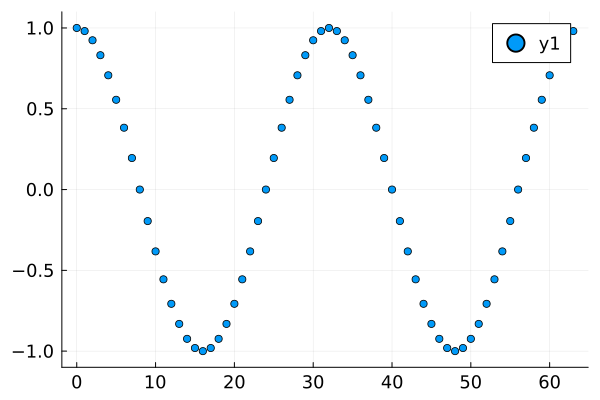

In [6]:
using FastTransforms

n = 64; m = 2
x = 0:n-1
f = exp.(2im * pi * m * x / n)
scatter(x, real.(f), ylim=(-1.1, 1.1))

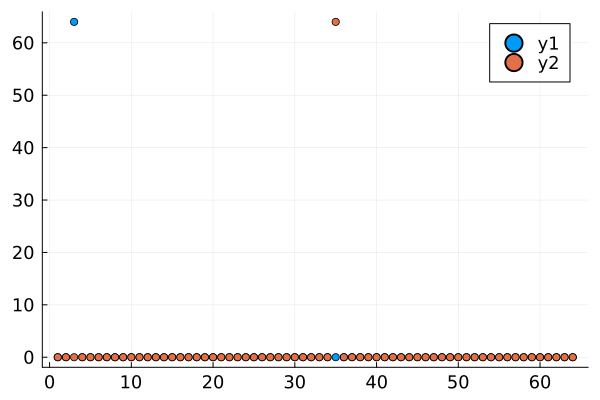

In [7]:
fhat = fft(f)
scatter([abs.(fhat), abs.(fftshift(fhat))])

# Transform a Gaussian bump $e^{-x^2}$



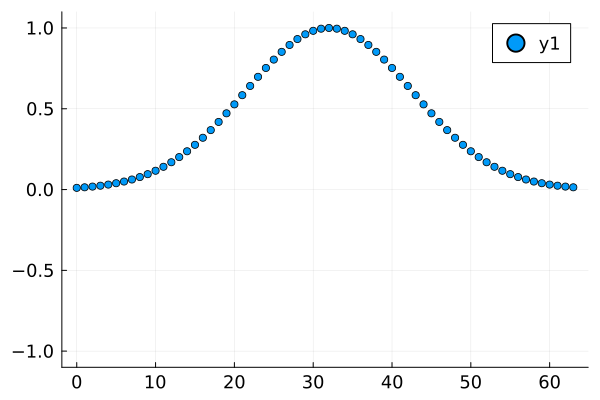

In [8]:
n = 64; w = 15
x = 0:n-1
f = exp.(-((x .- n/2)/w) .^ 2)
scatter(x, real.(f), ylim=(-1.1, 1.1))

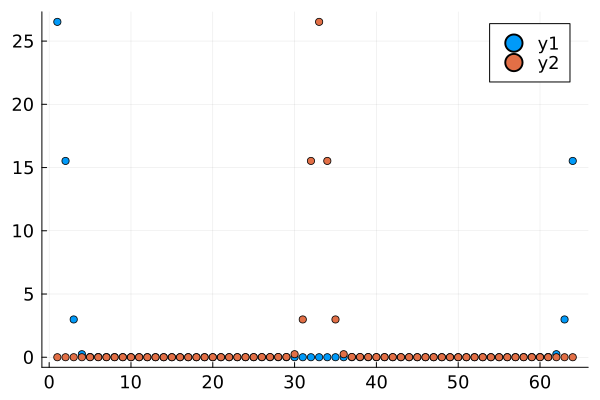

In [9]:
fhat = fft(f)
scatter([abs.(fhat), abs.(fftshift(fhat))])

# Compute derivatives using the Fourier transform

How do we differentiate this?

$$f(x) = \sum_k e^{i\theta_k x} \hat f_k$$


* Evidently, we need only compute
$$f'(x) = \mathcal F^{-1} (i \theta_k \hat f_k)$$

## Generalizations
* Non-power of 2
* Non-uniform grids
* Multiple dimensions
* Butterfly algorithms for integral operators
$$ (\mathcal K f)(x) = \int_{Y} K(x,y) f(y) dy $$
See [Poulson et al., A parallel butterfly algorithm](https://math.mit.edu/icg/papers/butterfly-parallel.pdf)

## Applications

* Everywhere in signal processing
* ECMWF global climate and weather model
* Particle-Mesh Ewald for long-range forces in molecular dynamics
* Turbulence simulation

## Parallel implications: Bisection bandwidth of the network

In [10]:
function vander_chebyshev(x, n=nothing)
    if isnothing(n)
        n = length(x) # Square by default
    end
    m = length(x)
    T = ones(m, n)
    if n > 1
        T[:, 2] = x
    end
    for k in 3:n
        #T[:, k] = x .* T[:, k-1]
        T[:, k] = 2 * x .* T[:,k-1] - T[:, k-2]
    end
    T
end

CosRange(a, b, n) = (a + b)/2 .+ (b - a)/2 * cos.(LinRange(0, π, n))

CosRange (generic function with 1 method)

# Derivative of a function on the `CosRange` points

In [11]:
function chebfft(y)
    # Adapted from Trefethen's Spectral Methods in Matlab
    n = length(y) - 1
    x = CosRange(-1, 1, n+1)
    Y = [y; reverse(y[2:n])]
    ii = 0:n-1
    U = real.(fft(Y))
    W = real.(ifft(1im * [ii; 0; 1-n:-1] .* U))
    w = zeros(n + 1)
    w[2:n] = -W[2:n] ./ sqrt.(1 .- x[2:n] .^ 2)
    w[1] = sum(ii .^ 2 .* U[ii .+ 1]) / n + .5 * n * U[n+1]
    w[n+1] = sum((-1) .^ (ii .+ 1) .* ii .^ 2 .* U[ii .+ 1]) / n + .5 * (-1) ^ (n+1) * n * U[n+1]
    w
end

chebfft([1,2,0,3])

4-element Vector{Float64}:
  -6.333333333333334
   1.3333333333333333
  -1.333333333333333
 -11.666666666666666

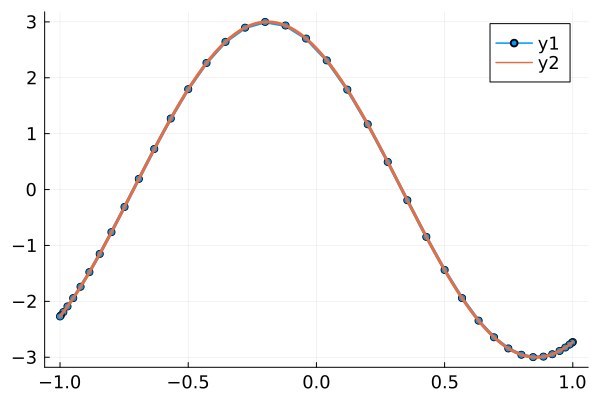

In [16]:
x = CosRange(-1, 1, 40)
g(x) = cos(3x - 1)
dg(x) = -3 * sin(3x - 1) # for verification
y = g.(x)
dy = chebfft(y)
plot(x, dy, marker=:circle)
plot!(dg)